In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
%pip install torchmetrics

Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.1 MB/s eta 0:00:00


In [2]:
!pip install --upgrade git+https://github.com/BorealisAI/advertorch.git
from advertorch.attacks import GradientSignAttack
from advertorch.attacks import PGDAttack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/BorealisAI/advertorch.git to /tmp/pip-req-build-zmwuoil0
  Running command git clone --filter=blob:none --quiet https://github.com/BorealisAI/advertorch.git /tmp/pip-req-build-zmwuoil0
  Resolved https://github.com/BorealisAI/advertorch.git to commit e063e341c87d9a621ae1a8f72c3507d5ea5bd327
  Preparing metadata (setup.py) ... done
  Created wheel for advertorch: filename=advertorch-0.2.4-py3-none-any.whl size=5706977 sha256=1fb7ff35248e1c5b64616859fdb7803127ad157a41b626b4a5f2b8c78ac3ac8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2o73934/wheels/7b/5d/e5/0a9d97c92ebded818df885e859a2119871a444d023ab875ffb
Successfully built advertorch


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchmetrics import Accuracy
import os
import gc

V = lambda x: x.detach().cpu().numpy()

torch.__version__

if not os.path.exists('figures'):
    os.mkdir('figures')
if not os.path.exists('figures/ensemble'):
    os.mkdir('figures/ensemble')


In [4]:
class Trainer:
    def __init__(self, model, dataset, device = 'cpu'):
        # val_data = dataset.data[-n_val:]
        # val_targets = dataset.targets[-n_val:]
        self.device = device
        self.model = model.to(device)
        self.dataset = dataset
        self.dataset.data = self.dataset.data.to(device)
        self.dataset.targets = self.dataset.targets.to(device)
        self.optim = torch.optim.Adam(self.model.parameters())
        self.history = {'train_loss': [], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
        self.accuracy = Accuracy(task='multiclass', num_classes=len(self.dataset.classes)).to(device)
        
    def fit(self, epochs =1, batch_size = 32, val_split=0.2, val_num = 1000, verbose=True):
        n = len(self.dataset.data)
        n_val = int(val_split*n)
        n_train = n-n_val 
        
        for ep in range(epochs):
            total_loss = []
            acc_acc = []
            for i in range(0,n_train, batch_size):
                x,y = self.dataset.batch_get(i,i+batch_size)

                self.optim.zero_grad()
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred, y)
                loss.backward()
                total_loss += [loss.item()+0]
                acc = self.accuracy(y_pred,y)
                acc_acc += [acc.item()+0]
                self.optim.step()
                if i % 20*batch_size and verbose:
                    print(f'{ep} Train: {i/n_train*100:.0f}\t loss: {loss:.3g},\t acc:{acc:.3f}', end='\r')
            self.history['train_loss'] += [mean(total_loss)]
            self.history['train_acc'] += [mean(acc_acc)]
            x,y = self.dataset.batch_get(-min(n_val, val_num), n)
            y_pred = self.model(x)
            loss = F.cross_entropy(y_pred, y)
            acc = self.accuracy(y_pred,y)
            if verbose:
                print(f'\n  Test:  \t loss: {loss:.3g},\t acc:{acc:.3f}')
            self.history['val_loss'] += [loss.item()+0]
            self.history['val_acc'] += [acc.item()+0]
        

# Group Action Activation layer
This layer implements the symmetry group action 
$$ U\sigma(H) \to U\pi(g,H)\sigma(gH) $$
by wrapping it around an activation function $\sigma' (x) = \pi(g,x)\sigma(gx) $, so that $U\sigma'(H) =  U\pi(g,H)\sigma(gH)$. 

In [5]:
from pickle import FALSE
import warnings

class GroupActivation(nn.Module):
    def __init__(self, in_features, nonlinearity = nn.Identity(), num_g = 1, eps = 1, T=None):
        """Replaces a nonlinear activation layer. 
        In normal mode, self(x) = nonlinearity(x)
        
        Args:
        in_features: # features of input; expects input of shape (batch, in_features, ...)
        num_g: number of group elements to use transform output
        eps: used in `g=exp(eps*T)` where `T` are gl_h Lie algebra elements. 
        T: if None, random T (of Lie algebra) will be created. If provided, with shape (num_g,h,h) 
            they will be used for computing g.   
        
        Flags:
        self.UPDATE_MODE: = False. If True, during forward pass, `num_g` batches of data
            will be stored as self.H for computing group rep $\pi(g,H) = \sigma(H)\sigma(gH)^+$. 
            self.H batch sizes are capped to in_features, as required for $pi(g,H)$.  
        self.G_ACT_MODE: = False. If True, uses group in forward pass 
            return size : batch_size,... -> num_g*batch_size,... 
        """
        super().__init__()
        self.in_features = in_features
        self.nonlinearity = nonlinearity
        self.num_g = num_g 
        self.eps = eps
        # in UPDATE_MODE, 
        self.UPDATE_MODE = False
        self.G_ACT_MODE_RANDOM = False # if True, uses random transform in forward pass 
        self.G_ACT_MODE_RANDOM_PERMUTE = False
        self.G_ACT_MODE_RANDOM_g = False
        self.PERMUTE_INTER = False
        self.invert_g_computed = False
        

        self.G_ACT_MODE = False # if True, uses group in forward pass 
        # in G-act mode: (batch_size -> num_g*batch_size)
        # self._G_INIT = False # set first time self.g is initialized 
        self.init_G(T)
        self.H = None
        
    def group_act_lower(self,H):
        """ input H -> gH """
        return torch.einsum('ncd...,bc...->nbd...', self.g, H)
    
    def batch_g_act(self,g,H):
        """input and output shape (num_g, batch, chan_out, ...)"""
        # return torch.einsum('ndc...,nbc...->nbd...', g, H)
        return torch.einsum('ncd...,nbc...->nbd...', g, H)
    
    def group_act_upper(self,sigma_gH):
        """ sigma(gH) -> pi(g,H0)*sigma(gH) 
        H0: batch used for computing pi(g,H0)
        H : new input 
        input and output shape (num_g, batch, chan_out, ...)
        """
        if self.G_ACT_MODE_RANDOM:
            I_diag = torch.ones(self.pi_g_H.size()[0], self.pi_g_H.size()[1])
            I = torch.diag_embed(I_diag)
            M = torch.rand_like(I)
            rand_M = I + self.eps * M
            rand_M = rand_M.to(DEVICE)
            return self.batch_g_act(rand_M, sigma_gH)
        elif self.G_ACT_MODE_RANDOM_PERMUTE:
            r = torch.randperm(self.pi_g_H.size()[0])
            c = torch.randperm(self.pi_g_H.size()[1])
            rand_pi_g_H = self.pi_g_H[r][:,c]
            r = torch.randperm(self.pi_g_H.size()[0])
            c = torch.randperm(self.pi_g_H.size()[1])
            rand_pi_g_H = rand_pi_g_H[r][:,c]
            rand_pi_g_H = rand_pi_g_H.to(DEVICE)
            return self.batch_g_act(rand_pi_g_H, sigma_gH)
        elif self.G_ACT_MODE_RANDOM_g:
            if not self.invert_g_computed:
                self.g_inv = torch.linalg.pinv(self.g)
                self.invert_g_computed = True
            return self.batch_g_act(self.g_inv, sigma_gH)
        else:
            return self.batch_g_act(self.pi_g_H, sigma_gH)
    
    
    def get_group_rep_upper(self,):
        """Compute $\pi(g,H) = \sigma(H) \sigma(gH)^+$ 
        Because the batch index is first (instead of last in our theory)
        we actually need `pi(g,H) = pinv(sigma(gH)) @ sigma(H)`. 
        We use torch.linalg.lstsq(A,B) = A.pinverse() @ B 
        (supposedly more numerically stable than pinverse). 
        """
        # to use lstsq, batch, channel must be last two dims
        # to (num_g, ..., batch, cin)  
        H_perm = self.H.permute(0,*torch.arange(3,self.H.ndim),1,2)
        H_perm = self.nonlinearity(H_perm)
        
        # stored H are (num_g, batch, cin, ...); regular H is (batch, cin,...)
        gH = self.batch_g_act(self.g, self.H)
        # to (num_g, ..., batch, channel)  
        gH_perm = gH.permute(0,*torch.arange(3,gH.ndim),1,2)
        gH_perm = self.nonlinearity(gH_perm)
        
        self.pi_g_H = torch.linalg.lstsq(gH_perm, H_perm).solution
        # move the (in,out) indices of g first
        # shape (num_g, cin, cin, ...)
        self.pi_g_H = self.pi_g_H.permute(0,-2,-1,*torch.arange(1, self.pi_g_H.ndim-2))
                
    def store_batch(self,H, noise=1e-4):
        """stores a queue of H of size num_g. 
        Note: because we need in_features >= batch, the batch size is capped to in_features.
        """
        H_capped = H[:self.in_features]
        
        if not hasattr(self,'_H_counter'):
            # initialize 
            self._H_counter = 0
            self.H = noise*torch.randn(self.num_g, *H_capped.shape).to(H_capped.device)
        
        self.H[self._H_counter] += H_capped
        # print(f'H batch {self._H_counter}/{self.num_g} stored')
        self._H_counter = (self._H_counter + 1) % self.num_g 
        
    def update_g(self,H):
        self.store_batch(H)
        if self._H_counter == 0:
            warnings.warn("Suffiecient H stored. Computing pi(g,H). "
                          "Consider setting self.UPDATE_MODE = False")
            self.get_group_rep_upper() 
        
    def forward(self, H):
        if self.UPDATE_MODE:
            # store batches 
            self.update_g(H)
            
        if not self.G_ACT_MODE: 
            return self.nonlinearity(H)
        elif self.PERMUTE_INTER:
            # [0.5(I+g)]^{-1} \sigma [0.5(I+g) H]
            # g = (I+ eps*0.5*(I+perm))/(1+eps)
            n = self.g.size()[0]
            h = H.size()[1]
            g = torch.zeros_like(self.g)
            g_inv = torch.zeros_like(self.g)

            for i in range(n):
                perm = torch.argsort(torch.rand(h))
                perm_inv = torch.argsort(perm)
                I = torch.eye(h)
                g[i] = (I + 0.5 * self.eps * (I + I[perm])) / (1 + self.eps)
                g_inv[i] = torch.linalg.pinv(g[i])
            gH = torch.einsum('ncd...,bc...->nbd...', g, H)
            gH = self.nonlinearity(gH)
            gH = torch.einsum('ncd...,nbc...->nbd...', g_inv, gH)
            return gH.flatten(start_dim=0, end_dim=1)
        else:
            gH = self.group_act_lower(H)
            gH = self.nonlinearity(gH)
            gH = self.group_act_upper(gH)
            # combine num_g and batch 
            return gH.flatten(start_dim=0, end_dim=1)
    
    def transform_U(self,):
        """ upper weight U -> g U = U pi(g,H) """
        pass 
    
    def init_G(self,T=None):
        self.T = T
        cin = self.in_features #self.H.shape[2] #(num_g, batch, cin, ...)
        
        if type(self.T) == type(None):
            if self.num_g > 0:
                self.T = torch.randn(self.num_g, cin, cin) / cin**.5
            else:
                self.T = torch.zeros(1,  cin, cin)
            
        else:
            assert type(self.T)==torch.Tensor
            self.num_g = len(self.T)
            
        # self.g = torch.eye(cin) + self.eps * self.T   
        self.g = torch.linalg.matrix_exp(self.eps * self.T)
        # self.g = torch.rand(self.num_g,cin,cin)
        self.T = nn.Parameter(self.T)
        self.g = nn.Parameter(self.g)
        
        self.T.requires_grad = False
        self.g.requires_grad = False
        

# cifar10

In [6]:
DEVICE = 'cuda'

In [7]:
# cifar10 = torchvision.datasets.CIFAR10('../data/',download=False)
# the data from CIFAR10 class is in PIL format and needs processing before we can use it in a pytorch model

class CIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, device='cpu', **kws):
        super().__init__(**kws)
        self.data = torch.tensor(self.data.transpose(0,3,1,2)/255. - 0.5, dtype=torch.float32).to(device)
        self.targets = torch.tensor(self.targets, dtype = torch.long).to(device)

    def __getitem__(self,i):
        return (self.data[i], self.targets[i])
    
    def batch_get(self,i,j):
        return (self.data[i:j], self.targets[i:j])

    
cif2= CIFAR10(root='../data/', download=True, device=DEVICE)
cif2_test = CIFAR10(root='../data/', train=False, device=DEVICE)
len(cif2_test.data), len(cif2.data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/


(10000, 50000)

In [8]:
m = nn.LeakyReLU(0.1)
def relu_sqr(x):
    return m(x) * m(x) + 1e-2 * x

In [9]:
#im-size 
p = 32
cin = 3
nf = 32

def adversarial_experiment(attack_method):
    if attack_method == 'FGSM':
        attack_param_list = [0, 0.003, 0.006, 0.009, 0.012] # fgsm eps
    elif attack_method == 'PGD':
        attack_param_list = [0, 1, 2, 3] # pgd iteration
    else:
        attack_param_list = []

    h = 16
    num_g = 200
    eps = 1e1

    acc_original = np.zeros((len(attack_param_list)))
    acc_group = np.zeros((len(attack_param_list)))
    acc_random = np.zeros((len(attack_param_list)))
    acc_random_permute = np.zeros((len(attack_param_list)))
    acc_random_g = np.zeros((len(attack_param_list)))
    acc_random_inter = np.zeros((len(attack_param_list)))
    val_loss_original = np.zeros((len(attack_param_list)))
    val_loss_group = np.zeros((len(attack_param_list)))
    val_loss_random = np.zeros((len(attack_param_list)))
    val_loss_random_permute = np.zeros((len(attack_param_list)))
    val_loss_random_g = np.zeros((len(attack_param_list)))
    val_loss_random_inter = np.zeros((len(attack_param_list)))

    for attack_param_idx, attack_param in enumerate(attack_param_list):
        ga = GroupActivation(h, num_g=num_g, nonlinearity=nn.LeakyReLU(0.1), eps=eps)
        model = nn.Sequential(
            nn.Conv2d(cin,nf,3, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear((p//2)**2*nf, h),
            ga,
            nn.Linear(h,10),
            nn.Softmax(1),
        ).to(DEVICE)

        model.trainer = Trainer(model, cif2, device = DEVICE)
        model.trainer.fit(10, batch_size=32, verbose=False)

        # define adversarial
        if attack_method == 'FGSM':
            adversary = GradientSignAttack(
                model, loss_fn=nn.CrossEntropyLoss(), 
                eps=attack_param,
                targeted=False)
        elif attack_method == 'PGD':
            adversary = PGDAttack(
                model, loss_fn=nn.CrossEntropyLoss(), 
                nb_iter=attack_param,
                targeted=False)
        else:
            adversary == None
        
        # attack
        last = -ga.in_features*ga.num_g
        num = 1000
        x_test,y_test = cif2.batch_get(-num+last,last)
        if attack_method != '' and attack_param > 0:
            print("test data perturbed")
            x_test = adversary.perturb(x_test,y_test)
            x_test = torch.clamp(adversary.perturb(x_test,y_test), 0, 1)
        
        # group
        ga.UPDATE_MODE = True
        ga.G_ACT_MODE = False

        x,y = cif2.batch_get(-ga.in_features*ga.num_g, len(cif2.data))
        h = ga.in_features
        for i in range(ga.num_g):
            yp = model(x[i*h:(i+1)*h])

        ga.UPDATE_MODE = False
        ga.G_ACT_MODE = False
        ga.G_ACT_MODE_RANDOM = False
        y_pred = model(x_test)

        ga.G_ACT_MODE = True
        y_group = model(x_test)

        ga.G_ACT_MODE_RANDOM = True
        ga.G_ACT_MODE_RANDOM_PERMUTE = False
        ga.G_ACT_MODE_RANDOM_g = False
        y_random = model(x_test)

        ga.G_ACT_MODE_RANDOM = False
        ga.G_ACT_MODE_RANDOM_PERMUTE = True
        ga.G_ACT_MODE_RANDOM_g = False
        y_random_permute = model(x_test)

        ga.G_ACT_MODE_RANDOM = False
        ga.G_ACT_MODE_RANDOM_PERMUTE = False
        ga.G_ACT_MODE_RANDOM_g = True
        y_random_g = model(x_test)

        ga.G_ACT_MODE_RANDOM_g = False
        ga.PERMUTE_INTER = True
        y_random_inter = model(x_test)

        accuracy = model.trainer.accuracy
        y_group = y_group.reshape(ga.num_g, *y_pred.shape )
        y_random = y_random.reshape(ga.num_g, *y_pred.shape )
        y_random_permute = y_random_permute.reshape(ga.num_g, *y_pred.shape )
        y_random_g = y_random_g.reshape(ga.num_g, *y_pred.shape )
        y_random_inter = y_random_inter.reshape(ga.num_g, *y_pred.shape )

        val_loss_original[attack_param_idx] = F.cross_entropy(y_pred, y_test).item()
        val_loss_group[attack_param_idx] = F.cross_entropy(y_group.mean(0), y_test).item()
        val_loss_random[attack_param_idx] = F.cross_entropy(y_random.mean(0), y_test).item()
        val_loss_random_permute[attack_param_idx] = F.cross_entropy(y_random_permute.mean(0), y_test).item()
        val_loss_random_g[attack_param_idx] = F.cross_entropy(y_random_g.mean(0), y_test).item()
        val_loss_random_inter[attack_param_idx] = F.cross_entropy(y_random_inter.mean(0), y_test).item()

        acc_original[attack_param_idx] = accuracy(y_pred, y_test)
        acc_group[attack_param_idx] = torch.mode(y_group.data.max(2)[1], 0).values.eq(y_test).long().cpu().sum() / y_test.size()[0]  # accuracy(y_group.mean(0), y)
        acc_random[attack_param_idx] = torch.mode(y_random.data.max(2)[1], 0).values.eq(y_test).long().cpu().sum() / y_test.size()[0]
        acc_random_permute[attack_param_idx] = torch.mode(y_random_permute.data.max(2)[1], 0).values.eq(y_test).long().cpu().sum() / y_test.size()[0]
        acc_random_g[attack_param_idx] = torch.mode(y_random_g.data.max(2)[1], 0).values.eq(y_test).long().cpu().sum() / y_test.size()[0]
        acc_random_inter[attack_param_idx] = torch.mode(y_random_inter.data.max(2)[1], 0).values.eq(y_test).long().cpu().sum() / y_test.size()[0]


        print(f'h={h} num_g={num_g} eps={eps} \
            Accuracy: \toriginal={accuracy(y_pred, y_test):.3f} \
            \tgroup:{accuracy(y_group.mean(0), y_test):.3f} \
            \trandom:{accuracy(y_random.mean(0), y_test):.3f} \
            \trandom_permute:{accuracy(y_random_permute.mean(0), y_test):.3f} \
            \trandom_g:{accuracy(y_random_g.mean(0), y_test):.3f} \
            \trandom_inter_g:{accuracy(y_random_inter.mean(0), y_test):.3f} \
            Validation loss: \toriginal={F.cross_entropy(y_pred, y_test).item():.6f} \
            \tgroup:{F.cross_entropy(y_group.mean(0), y_test).item():.6f} \
            \trandom:{F.cross_entropy(y_random.mean(0), y_test).item():.6f} \
            \trandom_permute:{F.cross_entropy(y_random_permute.mean(0), y_test).item():.6f} \
            \trandom_g:{F.cross_entropy(y_random_g.mean(0), y_test).item():.6f} \
            \trandom_inter_g:{F.cross_entropy(y_random_inter.mean(0), y_test).item():.6f}')
    exp_name = 'cnn_cifar_leakyrelu_{}_h16_g200_eps10'.format(attack_method)

    plt.figure()  
    plt.plot(attack_param_list, acc_original, label='original', linewidth=2.5)
    plt.plot(attack_param_list, acc_group, label='group', linewidth=2.5)
    plt.plot(attack_param_list, acc_random_g, label=r'$g^{-1}$', linewidth=2.5)
    plt.plot(attack_param_list, acc_random_inter, label='perm_interp', linewidth=2.5)

    plt.scatter(attack_param_list, acc_original)
    plt.scatter(attack_param_list, acc_group)
    plt.scatter(attack_param_list, acc_random_g)
    plt.scatter(attack_param_list, acc_random_inter)

    if attack_method == 'FGSM':
        plt.xlabel('FGSM epsilon', fontsize=20)
        plt.xticks([0, 0.004, 0.008, 0.012], fontsize=18)
    elif attack_method == 'PGD':
        plt.xlabel('PGD iterations', fontsize=20)
        plt.xticks([0, 1, 2, 3], fontsize=18)
    plt.ylabel('Accuracy', fontsize=20)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.savefig('figures/ensemble/{}.pdf'.format(exp_name), bbox_inches='tight')


<ipython-input-5-9a0d54ca6e1f>:124: UserWarning: Suffiecient H stored. Computing pi(g,H). Consider setting self.UPDATE_MODE = False
  warnings.warn("Suffiecient H stored. Computing pi(g,H). "


h=16 num_g=200 eps=10.0             Accuracy: 	original=0.598             	group:0.538             	random:0.095             	random_permute:0.102             	random_g:0.089             	random_inter_g:0.556             Validation loss: 	original=1.866778             	group:2.217163             	random:2.324443             	random_permute:2.302519             	random_g:2.303191             	random_inter_g:1.975447
test data perturbed
h=16 num_g=200 eps=10.0             Accuracy: 	original=0.210             	group:0.223             	random:0.099             	random_permute:0.089             	random_g:0.115             	random_inter_g:0.225             Validation loss: 	original=2.241979             	group:2.278067             	random:2.316189             	random_permute:2.302725             	random_g:2.302163             	random_inter_g:2.212218
test data perturbed
h=16 num_g=200 eps=10.0             Accuracy: 	original=0.133             	group:0.158             	random:0.111          

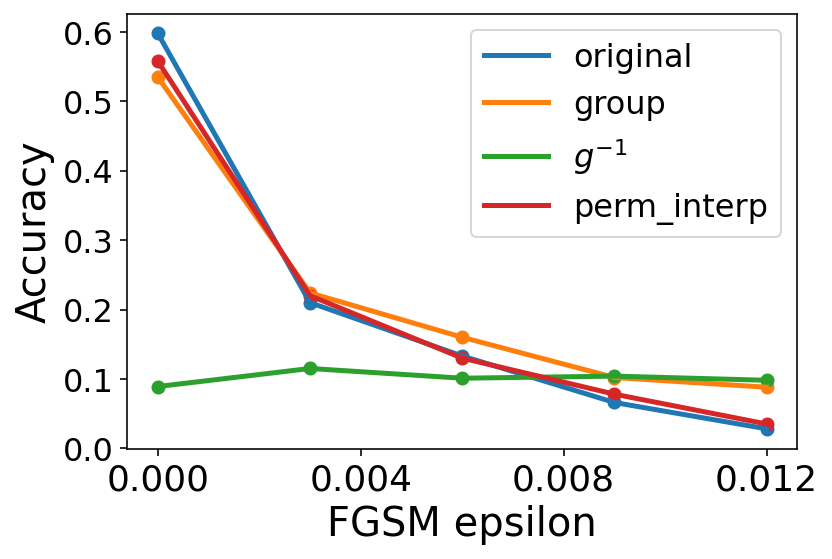

In [10]:
adversarial_experiment('FGSM')

In [11]:
# free cuda memory
torch.cuda.empty_cache()
gc.collect()

3661

<ipython-input-5-9a0d54ca6e1f>:124: UserWarning: Suffiecient H stored. Computing pi(g,H). Consider setting self.UPDATE_MODE = False
  warnings.warn("Suffiecient H stored. Computing pi(g,H). "


h=16 num_g=200 eps=10.0             Accuracy: 	original=0.576             	group:0.460             	random:0.099             	random_permute:0.079             	random_g:0.111             	random_inter_g:0.557             Validation loss: 	original=1.879377             	group:2.232063             	random:2.323686             	random_permute:2.303992             	random_g:2.300434             	random_inter_g:1.925576
test data perturbed
h=16 num_g=200 eps=10.0             Accuracy: 	original=0.006             	group:0.038             	random:0.101             	random_permute:0.094             	random_g:0.095             	random_inter_g:0.013             Validation loss: 	original=2.454458             	group:2.301566             	random:2.304966             	random_permute:2.304557             	random_g:2.302567             	random_inter_g:2.363975
test data perturbed
h=16 num_g=200 eps=10.0             Accuracy: 	original=0.000             	group:0.002             	random:0.087          

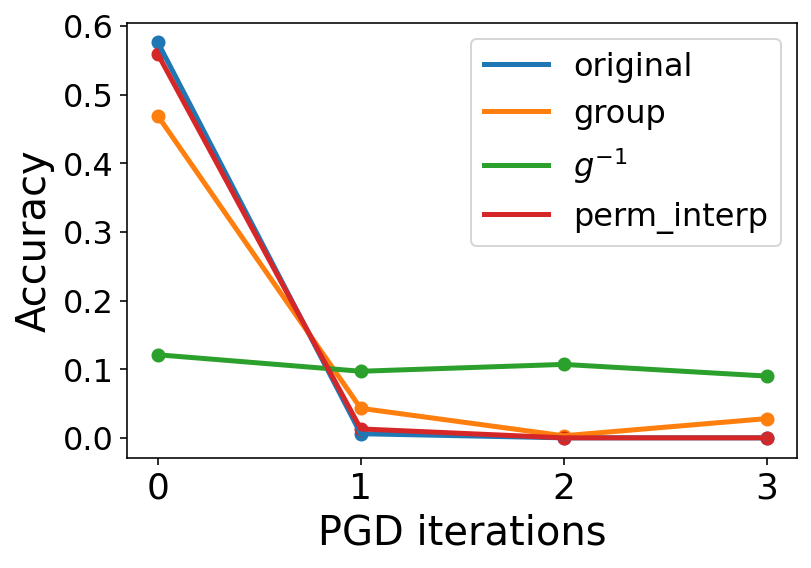

In [12]:
adversarial_experiment('PGD')